In [1]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant

from codes.gate_design import gate_coords
from codes.constants import scale
import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_indexes
from codes.utils import order_wavefunctions, ratio_Gaussian_curvature

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
from scipy.optimize import minimize, minimize_scalar

In [3]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
    {"device": {"thickness": {"dielectric": 1.0}}},
    {"gate": {"channel_width": 13.0, 'angle': np.pi/6, 'gap': 2}},
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [4]:
system = trijunction.Trijunction(config, optimize_phase_pairs=['left-right'])

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:32<00:00,  2.50s/it]


In [5]:
pair = 'left-right'
voltages = parameters.pair_voltages()

In [6]:
zero_potential = dict(
    zip(
        ta.array(system.site_coords[:, [0, 1]] - system.offset),
        np.zeros(len(system.site_coords)),
    )
)

In [7]:
kwant_args = list(system.optimiser_arguments().values())
kwant_args[-1] = kwant_args[-1][order_wavefunctions(pair)]

In [8]:
x = [-1.0e-3, -1.0e-3, -5.0e-3, 3e-3]
voltages = parameters.voltage_dict(x)

In [9]:
params = parameters.junction_parameters()
params.update(voltages)
params.update(potential=zero_potential)

In [10]:
opt_args = tuple([pair, params, kwant_args, 0.0])

In [238]:
import codes.optimization
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [201]:
kwant_sites = np.array([site.pos for site in system.trijunction.sites])
soft_threshold_indices = codes.utils.dep_acc_indexes(
    dict(zip(system.gate_names, system.gates_vertex)),
    system.nw_centers,
               kwant_sites,
               config['gate']['angle'],
               scale,
               10
               )

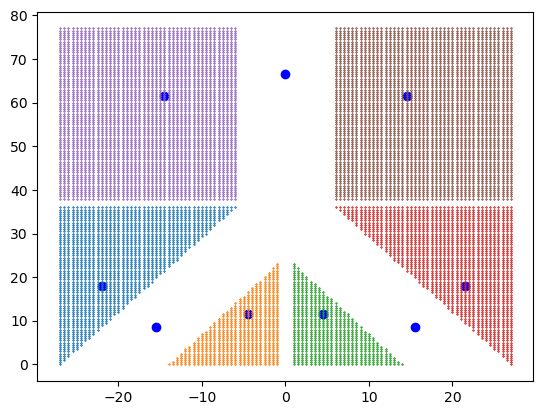

In [202]:
site_coords = system.grid_points[system.site_indices]
for index in np.hstack(list(soft_threshold_indices.values())):
    point = kwant_sites[index]/scale
    plt.scatter(point[0], point[1], c='b')

for key, value in system.poisson_system.regions.voltage.tag_points.items():
    if not key.startswith(('global', 'dirichlet')):
        coords = system.grid_points[value]
        plt.scatter(coords[:, 0], coords[:, 1], s = 0.1)

In [204]:
kwant_sites = np.array([site.pos for site in system.trijunction.sites])/scale
params.update({'dep_acc_index': soft_threshold_indices})

In [12]:
step_size = 1e-4
opt_args = tuple((pair, params, kwant_args, 0.0, step_size))
# optimization.loss(x, *opt_args)

In [78]:
sol1 = minimize(
            codes.optimization.loss,
            x,
            args=opt_args,
            method="trust-constr",
            # jac=codes.optimization.jacobian,
            options={
                "verbose":2,
                "initial_tr_radius":1e-3,
                "gtol":1e0
            },
        )

[-0.001 -0.001 -0.005  0.003]
0.18215093066514423 0.0010457858719185053
[-0.00100001 -0.001      -0.005       0.003     ]
0.18215840761036037 0.001045783097530719
[-0.001      -0.00100001 -0.005       0.003     ]
0.18215840761036295 0.001045774307988682
[-0.001      -0.001      -0.00500001  0.003     ]
0.18215182525535467 0.001045784715752685
[-0.001      -0.001      -0.005       0.00300001]
0.18214833773536593 0.0010457922068712012
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | -1.7478e-01 | 1.00e-03 | 5.04e+02 | 0.00e+00 |
[-0.00168395 -0.00168475 -0.00508268  0.00276232]
0.3247522534559975 0.0006490667788936922
[-0.00168397 -0.00168475 -0.00508268  0.00276232]
0.32476151473005255 0.0006490228077200424
[-0.00168395 -0.00168477 -0.00508268  0.00276232]
0.324761513363974 0.0006490611065385203
[-0.00168395 -0.00168475 -0.0050827   0.00276232]
0.3247548102473996 0.

In [12]:
optimiser_args = system.optimiser_arguments()


In [70]:
deltaV = np.linspace(-2, 5, 100) * 1e-3
scattering_region_density = kwant.operator.Density(system.trijunction, where=bounds)
kwant_sites = np.array([site.pos for site in system.trijunction.sites])

In [95]:
from tqdm import tqdm

In [239]:
# wave_functions = []
# ratios = []
# desired_couplings = []
# undesired_couplings = []
shape, loss = [], []
for v in tqdm(deltaV):
    a, b = codes.optimization.loss([-0.00343678 + v, 
                                    -0.00343654 + v, 
                                    -0.01941018,  
                                    0.00980045], 
                                   *opt_args
                                  )
    shape.append(a)
    loss.append(b)
#     params.update(parameters.voltage_dict([-0.00343678 + v, 
#                                            -0.00343654 + v, 
#                                            -0.01941018,  
#                                            0.00980045]))
#     linear_ham, numerical_hamiltonian = hamiltonian(system.trijunction, 
#                                     optimiser_args['linear_terms'], 
#                                     optimiser_args['kwant_params_fn'], 
#                                     **params)
#     energies, wave_function = eigsh(
#                 numerical_hamiltonian.tocsc(),
#                 6,
#                 sigma=0,
#                 return_eigenvectors=True,
#     )
#     transformed_hamiltonian = svd_transformation(
#     energies, wave_function, system.mlwf[order_wavefunctions('left-right')]
#     )

#     desired_couplings.append(np.abs(transformed_hamiltonian[0, 1]))
#     undesired_couplings.append(np.linalg.norm(transformed_hamiltonian[2:]))
    
#     step = system.geometry['grid_spacing']*scale

#     xmin, xmax, ymin, ymax = np.array(list(system.boundaries.values()))*scale
#     bounds = lambda site: (site.pos[0] > xmin 
#                         and site.pos[0] < xmax
#                         and site.pos[1] > ymin
#                         and site.pos[1] < ymax)
    
    
#     wavefunction_density = scattering_region_density(wave_function[:, 0])

#     scattering_sites = kwant_sites[[bounds(site) for site in system.trijunction.sites]]
#     x, y = scattering_sites[:, 0], scattering_sites[:, 1]
#     nx, ny = len(np.unique(x)), len(np.unique(y))

#     interpolated_wavefunction = wavefunction_density.reshape((nx, -1))
    
#     ratios.append(ratio_Gaussian_curvature(interpolated_wavefunction, step))


100%|██████████| 100/100 [13:39<00:00,  8.20s/it]


Text(0.5, 0, 'Detuning (V)')

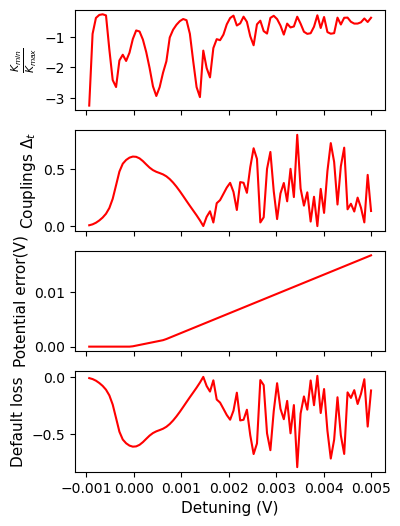

In [240]:
fig, ax = plt.subplots(4, 1, figsize=(4, 6), sharex=True)
r = 15
ax[0].plot(deltaV[r:], ratios[r:], '-', c='r')
# ax[0].vlines(0.0, -5, -0.5, 'r')

ax[0].set_ylabel(r'$\frac{K_{min}}{K_{max}}$', fontsize=11)

ax[1].plot(deltaV[r:], np.array(desired_couplings)[r:]/40e-6, '-', c='r')
ax[1].set_ylabel(r'Couplings $\Delta_t$', fontsize=11)


ax[2].plot(deltaV[r:], np.array(shape)[r:], '-', c='r')
ax[2].set_ylabel('Potential error(V)', fontsize=11)

ax[3].plot(deltaV[r:],( np.array(loss) - np.array(shape))[r:]/40e-6+ np.array(shape)[r:], '-', c='r')
ax[3].set_ylabel('Default loss', fontsize=11)

ax[3].set_xlabel('Detuning (V)', fontsize=11)

In [236]:
params.update(parameters.voltage_dict([-0.00343678 + 0.003, 
                                       -0.00343654 + 0.003, 
                                       -0.01941018,  
                                       0.00980045]))
linear_ham, numerical_hamiltonian = hamiltonian(system.trijunction, 
                                optimiser_args['linear_terms'], 
                                optimiser_args['kwant_params_fn'], 
                                **params)
loss = 0
for gate, index in params['dep_acc_index'].items():
    diff = np.real(linear_ham.diagonal()[::4][index]) - codes.parameters.bands[0]
    if gate in pair:
        if diff > 0:
            print(gate, diff)
            loss += diff    
    else:
        if diff < 0:
            print(gate, diff)
            loss += diff

left_1 -0.002109621460826752
left_2 -0.0026941257538559255
right_1 -0.00269425951073958
right_2 -0.0021427853056914213


In [237]:
loss

-0.00964079203111368

In [68]:
vg1 = np.linspace(-6, 6, couplings[0.005].shape[0])

In [86]:
wave_function.shape

(115112, 6)

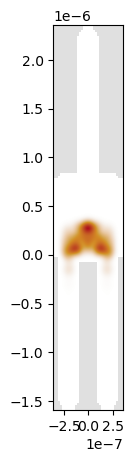

In [90]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
kax = kwant.plotter.density(system.trijunction, 
                            density(wave_function.T[0]), 
                            ax=ax, 
                            colorbar=False);

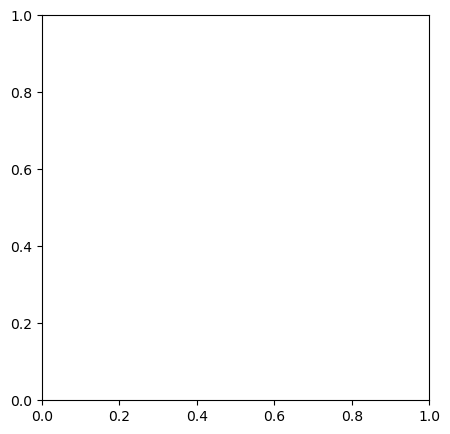

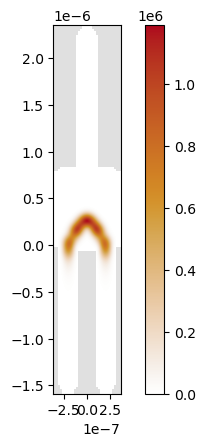

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5), sharey= True)

density = kwant.operator.Density(system.trijunction, np.eye(4))
for i, vec in enumerate(wave_functions.T[[0]]):
    kax = kwant.plotter.density(system.trijunction, density(vec), colorbar=True);


In [81]:
transformed_hamiltonian = svd_transformation(
    energies, wave_functions, system.mlwf[order_wavefunctions('left-right')]
)

desired = np.abs(transformed_hamiltonian[0, 1])
undesired = np.linalg.norm(transformed_hamiltonian[2:])

### Soft-threshold for the wavefunction curvature


If $\frac{K_{min}}{K_{max}}$ > -0.5, add $\frac{K_{min}}{K_{max}}$ to the loss. 

where $K_{max}$ and $K_{min}$ are the maximum and minimum Gaussian curvature of the wavefunction probalility $|\psi(x)|^2$. -0.5 is the soft-threshold. Ideally when the threshold is zero, there are no saddle points, as the determinant of the hessian matrix is all positive. We cannot have the threshold to be positive or zero, because there are many points at which the curvature is zero (those are optimal points). Hence we use a softer-threshold.
This makes the minimal Gaussian curvature flat, thereby avoiding many saddle points. This way the number of peaks in the wavefunction can be reduced to a single peak. 

Example for obtaining Gaussian curvature of a function with saddle points
```python
x, step = y, _ = np.linspace(-1, 1, retstep=True)
x = x.reshape(-1, 1); y = y.reshape(1, -1)
z = x**2 + 3*x*y + 2*y**2
hessian = np.array(np.gradient(np.gradient(z, step), step, axis=[1, 2]))
curvature = np.linalg.det(hessian.transpose([2, 3, 0, 1]))[2:-2, 2:-2]
```

In [167]:
step = system.geometry['grid_spacing']*scale

xmin, xmax, ymin, ymax = np.array(list(system.boundaries.values()))*scale
bounds = lambda site: (site.pos[0] > xmin 
                    and site.pos[0] < xmax
                    and site.pos[1] > ymin
                    and site.pos[1] < ymax)
scattering_region_density = kwant.operator.Density(system.trijunction, where=bounds)


In [183]:
wavefunction_density = scattering_region_density(wave_functions[:, 0])

scattering_sites = kwant_sites[[bounds(site) for site in system.trijunction.sites]]
x, y = scattering_sites[:, 0], scattering_sites[:, 1]
nx, ny = len(np.unique(x)), len(np.unique(y))

interpolated_wavefunction = wavefunction_density.reshape((nx, -1))

In [189]:
ratio = ratio_Gaussian_curvature(interpolated_wavefunction, step)